### Artistic style transfer

This is the advanced topic, but this is a good example of what Neural networks are capabale on.

For this task we will be using completely different framework: Keras and Tensorflow

This notebook is based on paper: [https://arxiv.org/abs/1508.06576]

In [1]:
%matplotlib inline 


In [2]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

from matplotlib import pyplot as plt



Using TensorFlow backend.


In [7]:
import sys
sys.path.append('../')

import common.workshop as workshop
workshop.download_art_generation()
DATA_DIR='art'


File art/obj1-cat.jpg is already downloaded.
File art/obj2-dog.jpg is already downloaded.
File art/style1-van-gogh.jpg is already downloaded.
File art/style2-dali.jpg is already downloaded.


In [8]:
!ls ./art

obj1-cat.jpg  obj2-dog.jpg  style1-van-gogh.jpg  style2-dali.jpg


The following command downloads image, use it to fetch your own style and object

In [9]:
!wget 'https://cdn.pixabay.com/photo/2018/02/09/21/46/rose-3142529__340.jpg' && mv 'rose-3142529__340.jpg' 'art/obj4.jpg'

--2019-03-27 14:41:06--  https://cdn.pixabay.com/photo/2018/02/09/21/46/rose-3142529__340.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.37.44, 104.18.36.44, 2606:4700:30::6812:242c, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.37.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31799 (31K) [image/jpeg]
Saving to: ‘rose-3142529__340.jpg’

rose-3142529__340.j 100%[===================>]  31.05K  --.-KB/s    in 0.001s  

2019-03-27 14:41:06 (32.9 MB/s) - ‘rose-3142529__340.jpg’ saved [31799/31799]



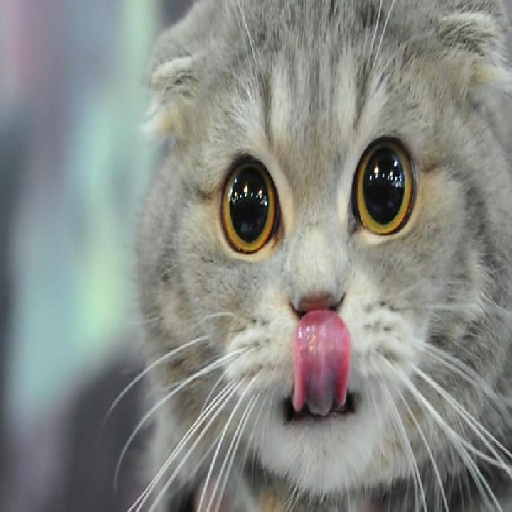

In [10]:
height = 512
width = 512

content_image_path = DATA_DIR+"/obj1-cat.jpg"
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image


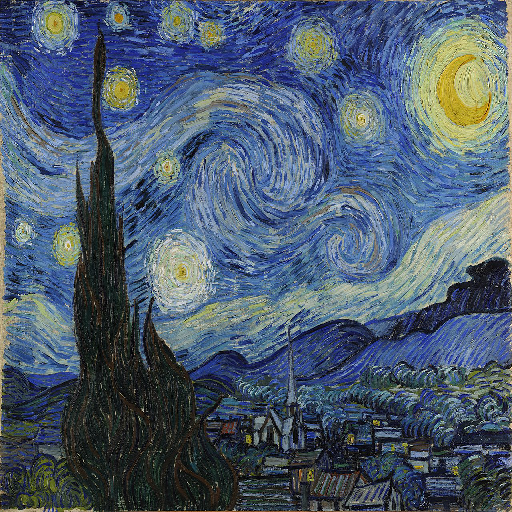

In [11]:
style_image_path = DATA_DIR+"/style1-van-gogh.jpg"
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image


In [12]:

# Since we will be using pretrained network(VGG16), we need to normalize our images,
# So they will be in the same distribution as images that are fed VGG network.
# For this we just subtract constants and replace arrays from RGB to BGR
# More: https://forums.fast.ai/t/how-is-vgg16-mean-calculated/4577
def prepare_img(image):
    img_array = np.asarray(image, dtype='float32')
    img_array = np.expand_dims(img_array, axis=0)
    img_array[:, :, :, 0] -= 103.939
    img_array[:, :, :, 1] -= 116.779
    img_array[:, :, :, 2] -= 123.68
    # Flip the ordering of the multi-dimensional array from RGB to BGR (the ordering used in the paper).
    img_array = img_array[:, :, :, ::-1]
    return img_array


In [13]:
content_array = prepare_img(content_image)
style_array = prepare_img(style_image)

The next step, we need to define variables

In [14]:

content_image_var = backend.variable(content_array)
style_image_var = backend.variable(style_array)
combination_image_var = backend.placeholder((1, height, width, 3))


Next, we define the input data into our netwrok. It will be train example with batch_size=3,
where the first image is the content image, the second is the style image, and the third is the combination image, that we will be refining

In [15]:
input_tensor = backend.concatenate([content_image_var, style_image_var, combination_image_var], axis=0)


Fetch our pretrained model

In [16]:
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)


Lest look at layers that is has

In [17]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers


{'input_1': <tf.Tensor 'concat:0' shape=(3, 512, 512, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <t

In the following cells we will be defining our loss function. It will be a complex function that consist of three parts:

    total_loss = content_loss + style_loss + total_variational_loss
    
The goal of the artistic style transfer is to adjust the combinational image so we will reach the minimum loss

As defined above, on each step, we will feed the network a batch of size three. But the only image that will be change from iteration to iteration is the combinational image!

In [18]:
# These are the standard weights, change them and rerun cells to see different results!
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0


In [19]:
loss = backend.variable(0.)


Next, we define the content loss. The content loss if the sum of squared differences between combination and content image for a particular layer. Note, the layer block2_conv2 picked from the paper specified in the header of this notebook.

In [20]:
def content_loss(layers, layer_name, content_weight):
    layer = layers[layer_name]
    content_image_features = layer[0, :, :, :]
    combination_features = layer[2, :, :, :]
    return content_weight * backend.sum(backend.square(combination_features - content_image_features))

closs = content_loss(layers, 'block2_conv2', content_weight)

print(closs)


Tensor("mul:0", shape=(), dtype=float32)


Below we define our style loss function. In a simplified version, it is basically a sum of squared errors across all parameters from layes between style image and the combination image.

Note: style loss is spread across several layers, change layers to see different results!

In [21]:

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def style_loss_single_layer(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def style_loss(layers, feature_layers, style_weight):
    loss = backend.variable(0.)
    for layer_name in feature_layers:
        layer_features = layers[layer_name]
        style_features = layer_features[1,:,:,:]
        combination_features = layer_features[2,:,:,:]
        sl = style_loss_single_layer(style_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
    return loss

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

sloss = style_loss(layers, feature_layers, style_weight)


And the last part of the loss is the total_variational loss, that serves as a regularizer

In [22]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

def compute_total_loss():
    return total_variation_weight * total_variation_loss(combination_image_var)


In [23]:

# Compute loss and the gradient of the loss as tensor variables
loss = sloss + closs + compute_total_loss()
grads = backend.gradients(loss, combination_image_var)


In [24]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image_var], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()


In [25]:

def to_img(vector, height, width):
    img = np.copy(vector.reshape((height, width, 3)))
    img = img[:, :, ::-1]
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = np.clip(img, 0, 255).astype('uint8')
    return img

def show_img(img):
    plt.imshow(img)
    plt.show()
    


In [26]:
# We start withe the random noise
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    # Note, we are using https://en.wikipedia.org/wiki/Limited-memory_BFGS optimizer
    # More: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    

Start of iteration 0
Current loss value: 62408460000.0
Iteration 0 completed in 21s
Start of iteration 1
Current loss value: 40581214000.0
Iteration 1 completed in 18s
Start of iteration 2
Current loss value: 34880390000.0
Iteration 2 completed in 18s
Start of iteration 3
Current loss value: 33191088000.0
Iteration 3 completed in 18s
Start of iteration 4
Current loss value: 32400330000.0
Iteration 4 completed in 18s
Start of iteration 5
Current loss value: 31926899000.0
Iteration 5 completed in 18s
Start of iteration 6
Current loss value: 31652776000.0
Iteration 6 completed in 18s
Start of iteration 7
Current loss value: 31436302000.0
Iteration 7 completed in 19s
Start of iteration 8
Current loss value: 31284568000.0
Iteration 8 completed in 19s
Start of iteration 9
Current loss value: 31142800000.0
Iteration 9 completed in 19s


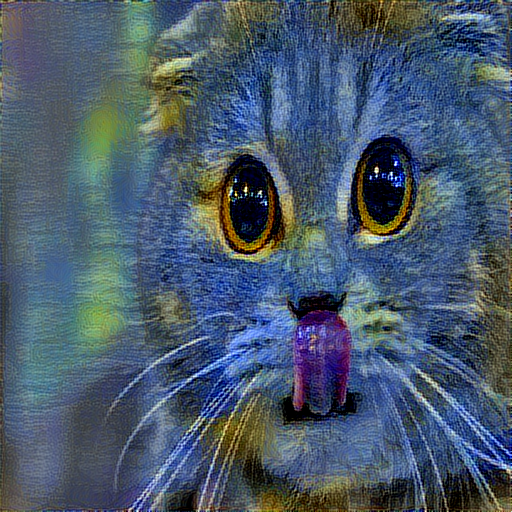

In [27]:
Image.fromarray(to_img(x, height, width))